# House Prices Prediction using XGBoost Regression

Hometask №3 for the machine learning course at HSE University, 2023.

Original dataset provided by [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

In [268]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

Get and join the data:

In [269]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

frame = pd.concat([train, test])

frame.shape

(2919, 81)

Look deeper:

In [270]:
frame.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


Look at the target variable:


In [271]:
frame["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Look at the target variable distribution:

*(Normal distribution with a shift to the left)*

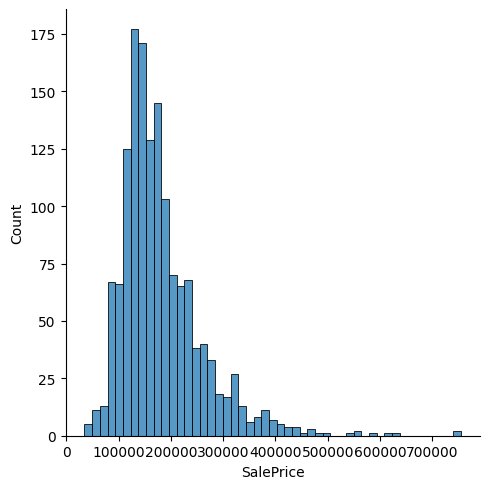

In [272]:
sns.displot(frame["SalePrice"])

Look at datatypes and missing values:

*(Need processing)*

In [273]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

Look carefully at missing values:

In [274]:
missing_total = frame.isnull().sum().sort_values(ascending=False)
missing_percent = (frame.isnull().sum() / frame.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_total, missing_percent], axis=1, keys=["Total", "Percent"])

missing_data.head(20)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


Remove columns with >15% missing values:

In [275]:
missing = [
    col for col in frame.columns
         if missing_percent[col] > .15 and col != "SalePrice"
]

frame = frame.drop(missing, axis=1)

frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

Fill missing values with Imputation:

In [276]:
imputer = SimpleImputer(strategy="most_frequent")

imputer.fit_transform(frame)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Transform categories:

In [277]:
for feature in frame.columns:
    if frame[feature].dtype == 'object':
       frame[feature] = pd.Categorical(frame[feature]).codes

frame.shape

(2919, 75)

Build, train and validate the model:

In [278]:
# 1. extract train and validation data

train = frame.iloc[:1460]

y = train.SalePrice
x = train.drop(["SalePrice"], axis=1)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)

# 2. build model

model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.25)

# 3. train model

model.fit(train_x, train_y)

# 4. validate model

predictions = model.predict(test_x)

np.sqrt(mean_squared_error(np.log(test_y), np.log(predictions)))

0.13026308701086942

Get prediction for the test data to submit on Kaggle:

In [279]:
feature_names = model.get_booster().feature_names

submission = pd.read_csv("./test.csv")

test = frame.iloc[1460:][feature_names]

submission["SalePrice"] = model.predict(test)

submission = submission[['Id','SalePrice']].copy()

submission.to_csv("./output/submission.csv", index=False)

submission

,Id,SalePrice
0,1461,130353.742188
1,1462,150835.359375
2,1463,177733.453125
3,1464,191794.390625
4,1465,200402.484375
...,...,...
1454,2915,80949.921875
1455,2916,88062.648438
1456,2917,161552.468750
1457,2918,112513.218750
